# AGH - Deep Learning in Medical Image Analysis I

Author: Marek Wodziński

Contact: wodzinski@agh.edu.pl

You are allowed to use these materials for all purposes as long as the credit is given.


# Laboratory 3 - Datasets, Dataloaders

The goal of the Laboratory 3 is to:
<ul>
  <li> Get familiar with loading images using various I/O libraries.
  <li> Implement several datasets/dataloaders in PyTorch.
  <li> Understand the parameters and limitations of PyTorch dataloaders.
</ul>

You are going to start with simple built-in datasets in torchvision to get familiar with the loading hyperparameters. Then, you will implement three datasets/dataloaders using real medical images.

### Part I - Basic Dataloaders

You are going to start with build-in dataset available in **torchvision** - a library dedicated computer vision in PyTorch. It contains several frequently used datasets for prototyping, like MNIST, CIFAR10 and others. You can check the list of available dataset under the following link:

https://pytorch.org/vision/stable/datasets.html

During this laboratory you will use the MNIST dataset.

It is recommended to read:
https://pytorch.org/tutorials/beginner/basics/data_tutorial.html before continuing.

Let's start with creating the Dataset object: 


In [1]:
import numpy as np
import torch as tc
import matplotlib.pyplot as plt
import torchvision as tv
import os
# !pip install SimpleITK
import SimpleITK as sitk


download = False # Set to True only during the first run or after reseting the notebook, then set to False
train = False # Let's use the testing dataset
root = '/content/MNIST' # Let's download the dataset to the /content folder
transform = tv.transforms.ToTensor() # Used to convert the PIL image to PyTorch Tensor
mnist_dataset = tv.datasets.MNIST(
    root=root,
    train=train,
    download=download,
    transform=transform
) # TODO - create the Dataset object

print(f"Testing MNIST dataset length: {len(mnist_dataset)}")

c:\Users\juziu\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\juziu\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
c:\Users\juziu\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\.libs\libopenblas64__v0.3.23-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


Testing MNIST dataset length: 10000


Now create the assosciated Dataloader:


In [2]:
batch_size = 16 # The number of cases to be loaded at once
shuffle = False # Whether to load the dataset in random order
num_workers = 2 # The number of CPU cores used by the DataLoader

mnist_dataloader = tc.utils.data.DataLoader(
    mnist_dataset,
    batch_size=batch_size,
    shuffle=shuffle,
    num_workers=num_workers
) #TODO - create the dataloader object

Now, let's iterate through the dataloader and visualize the first batch.

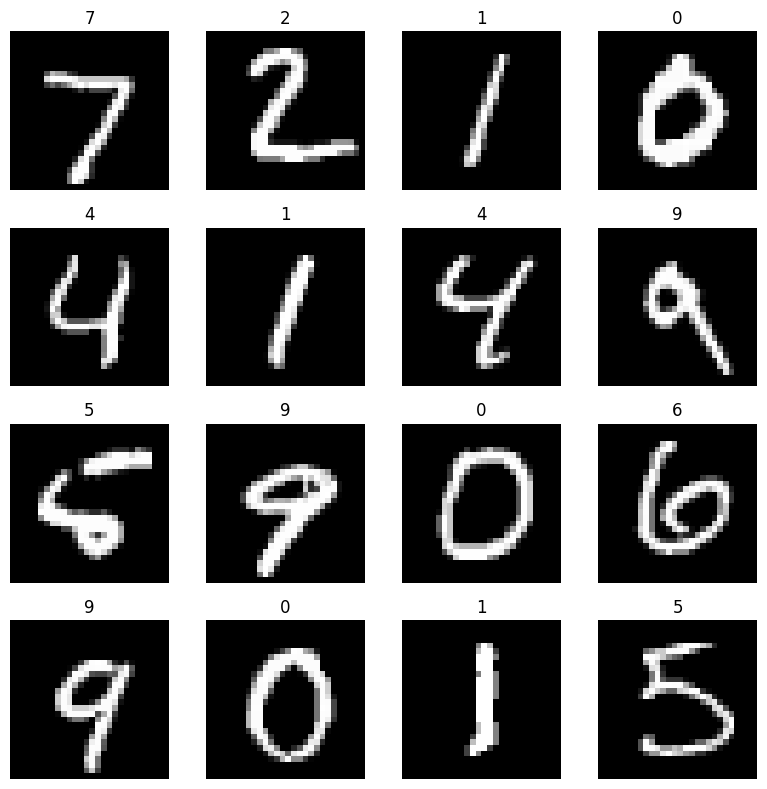

In [3]:
for images, classes in mnist_dataloader:
    # Let's assume that the batch size is equal to 16
    # - implement the visualization below
    fig, axs = plt.subplots(4, 4, figsize=(8, 8))
    for i, image in enumerate(images):
        row_id = i // 4
        col_id = i % 4
        axs[row_id][col_id].set_title(classes[i].item())
        axs[row_id][col_id].imshow(image[0], cmap='gray')
        axs[row_id][col_id].axis("off")
    fig.tight_layout()
    break

You have used a built-in dataset and configured dataloader associated with the dataset. Next, you are going to implement several Dataset objects dedicated to medical images. 

### Part II - MRI Dataloader (simple)

In the first part of the laboratory you loaded the built-in MNIST dataset.

However, in practice, you usually have your own dataset. Independent whether the dataset is public or private, it requires a dedicated Dataset object to load the assosciated images/volumes/annotations.

To implement your own Dataset object you need to:
<ul>
  <li> Create your own class with the **tc.utils.data.Dataset** as the parent class.
  <li> Overload the **__init__** function responsible for defining the parameters assosciated with the given Dataset and initializing the logic used during loading.
  <li> Overload the **__len__** function defining the size of the Dataset (number of cases).
  <li> Overload the **__getitem__** function responsible for loading a single case within the dataset (images + additional metadata like labels or annotations).
</ul>

In the first part you are going to use the dataset containing magnetic resonance images of brain dedicated to the tumor classification.

Please download the dataset from:

https://www.kaggle.com/datasets/sartajbhuvaji/brain-tumor-classification-mri?resource=download

, and upload it to your Google Drive or directly to the Google Colaboratory **/content** folder.

If you plan to use the Google Drive (better option), you should:

On the left, under the **Files** bar, find a button called **Mount Drive** and choose your Google Drive.
It should appear in the **/content** folder as a **drive** or with different name if using non-default settings. Then you will need to unzip the dataset file to a selected path within your Google Drive.

In [4]:
input_file = None # Path to the "Brain_MRI.zip"
output_folder = 'Brain_MRI' # Path to the folder where you would like to unzip the input ".zip" file

print(f"Input file path: {input_file}")
print(f"Output folder path: {output_folder}")

# !unzip {input_file} -d {output_folder} # Do this only once, them comment out this command

Input file path: None
Output folder path: Brain_MRI


Explore the unzipped data. You should see two folders inside the parent folder: **Training** and **Testing**. Inside these folders you will find four additional folders called: **pituitary_tumor**, **glioma**, **meningioma**, and **no_tumor**. All images inside these folder contain 2-D MRI slices presenting one of the classes.

Please note that the problem is simplfied - the cases are represented only by one 2-D slice from a 3-D MRI volume. In reality - the MRI imagaes are 3-D volumes containing hunderds of 2-D slices for each case.

The next task is to implement a dedicated Dataset object:

In [5]:
from PIL import Image

class BrainMRIDataset(tc.utils.data.Dataset):
    def __init__(self, dataset_path : str, mode : str="training"):
        self.dataset_path = dataset_path
        self.mode = mode # "training" or "testing"

        if self.mode == "training":
            self.data_path = os.path.join(self.dataset_path, "Training")
        elif self.mode == "testing":
            self.data_path = os.path.join(self.dataset_path, "Testing")
        else:
            raise ValueError("Unsupported mode.")

        self.classes = os.listdir(self.data_path) # Assumption that the classes are represented by the folder names
        print(f"Available classes: {self.classes}")
        self.classes_dict = {self.classes[i]: i for i in range(len(self.classes))}
        print(f"Classes dict: {self.classes_dict}") # Mapping from the classes to numbers

        # Creation of all training cases in the form of list containing tuples with: (path_to_file, class_number)
        self.cases = []        
        for current_class in self.classes:
            for current_case in os.listdir(os.path.join(self.data_path, current_class)):
                # accumulate the self.cases with (case_path, case_class) pairs                
                self.cases.append((current_case, self.classes_dict[current_class]))

    def __len__(self):
        # Overload the function responsible to determine the size of the dataset
        return len(self.cases)

    def __getitem__(self, idx):
        # Overload the function responsible to load a single image from the dataset
        current_case = self.cases[idx]
        current_path = current_case[0] # TODO
        current_class = current_case[1] # TODO
        
        new_size = (224, 224)
        
        current_image = np.array(
            Image.open(
                os.path.join(
                    self.data_path, self.classes[current_class], current_path
                )
            ).resize(new_size)  # resize do (224x224)
             .convert('L')      # grayscale conversion
        ).astype(np.float32)

        # All images should have the same resolution
        # Resample the images to the same resolution (224x224), then convert the images to grayscale (if not already) and normalize to [0-1] values

        current_image *= (255.0/current_image.max())
        
        # To pytorch
        current_image = tc.from_numpy(current_image)
    
        # Unsqueeze for one channel to be returned (for input to the network)
        return current_image.unsqueeze(0), current_class

Now create the DataLoader responsible for loading cases from the Dataset. Notice that you do not have to make any changes with respect to the DataLoader - the interface is the same as long as the Dataset is implemented correctly.

In [6]:
mri_dataset = BrainMRIDataset(output_folder) # - create the dataset object
batch_size = 16
shuffle = True
mri_dataloader = tc.utils.data.DataLoader(
    mri_dataset,
    batch_size=batch_size,
    shuffle=shuffle
) #TODO - create the dataloader object

Available classes: ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
Classes dict: {'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}


Finally, verify whether the images are loaded correctly:

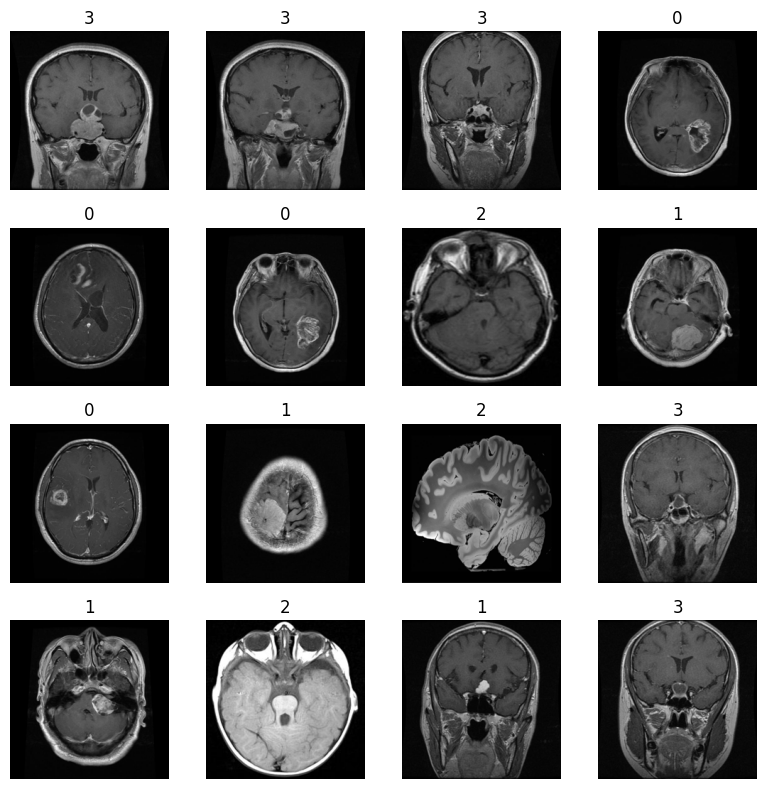

In [7]:
for images, classes in mri_dataloader:
    # Assume the batch size is equal to 16
    # TODO - show the images as below
    fig, axs = plt.subplots(4, 4, figsize=(8, 8))
    for i, image in enumerate(images):
        row_id = i // 4
        col_id = i % 4
        axs[row_id][col_id].set_title(classes[i].item())
        axs[row_id][col_id].imshow(image[0], cmap='gray')
        axs[row_id][col_id].axis("off")
    fig.tight_layout()
    break

In this part you implemented a basic dataloader dedicated to MRI images. However, in practice, it is better to make the Dataset object a bit more complicated. This is the task for the next part.

### Part III - MRI Dataloader (extended)

In practice implementing the whole logic in the **__init__** function (as in the example above) is impractical. Better idea is to propose a unified representation and seperate the logic for pairing images with classes or other metadata outside the Dataset object.

The reason for this is connected with the fact that there may be more datasets than one that you would like to use at the same time and split or combine them whenever necessary. This is difficult if the datasets were acquired in different institutions without standarization.

Therefore, now slightly modify the Dataset from the previous Part by using **pandas** library to create and split the input dataset. The **csv** file should contain two columns: relative input path and the corresponding class. This way, you can firstly preprocess different datasets to the same representation and then combine them or split using just the **csv** file.

Note: In practice, for larger dataset, instead of using **csv** files you use tools dedicated to databases.

First, parse the dataset into a csv representation:

In [8]:
import pandas as pd

dataset_path = output_folder
training_csv_path = os.path.join(dataset_path, "training.csv")
testing_csv_path = os.path.join(dataset_path, "testing.csv")

# Repeat the process from the __init__ function to create pandas dataframe
# containing three components: (image_path, image_class_number, image_class_name)

classes = os.listdir(os.path.join(dataset_path, "Training")) # list all the available classes
print(f"Available classes: {classes}")
classes_dict = {classes[i]: i for i in range(len(classes))}
print(f"Classes dict: {classes_dict}")

training_cases = []
testing_cases = []
for case_type in ["Training", "Testing"]: # for test and train
    # print(os.listdir(dataset_path, case_type, classes))
    # print(dataset_path, case_type, classes)
    for current_class in os.listdir(os.path.join(dataset_path, case_type)):
        # TODO - populate both the training and testing cases with the tuples
        curr_class_list = os.listdir(os.path.join(output_folder, case_type, current_class))
        curr_class_list = [(element, classes_dict[current_class], current_class) for element in curr_class_list]
        if case_type == "Training":
            training_cases.extend(curr_class_list)
        elif case_type == "Testing":
            testing_cases.extend(curr_class_list)
        else:
            raise ValueError("Unexpected error.")

# - create the dataframes and save them to .csv
train_df = pd.DataFrame(training_cases)
test_df = pd.DataFrame(testing_cases)

train_df.to_csv(training_csv_path)
test_df.to_csv(testing_csv_path)

Available classes: ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
Classes dict: {'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}


Now modify the Dataset class to use **csv** files instead of implementing the logic inside the **init** function.

In [9]:
class BrainDataset(tc.utils.data.Dataset):
    def __init__(self, dataset_path, csv_path, transforms=None, z_norm=False):
        self.dataset_path = dataset_path
        self.csv_path = csv_path
        self.dataframe = pd.read_csv(self.csv_path, names=['element', 'class', 'name']) # - read the previously created csv
        self.dataframe = self.dataframe.loc[self.dataframe.index.dropna()]

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        # - repeat the steps from the previous dataloader
        row = self.dataframe.iloc[idx]
                
        current_case = row[0]
        current_class = row[1]
        current_path = row[2]
        
        new_size = (224, 224)
        
        current_image = np.array(
            Image.open(
                os.path.join(
                    self.dataset_path, current_path, current_case
                )
            ).resize(new_size)  # resize to (224x224)
            .convert('L')      # grayscale conversion
        ).astype(np.float32)
        
        # All images should have the same resolution
        # Resample the images to the same resolution (224x224), then convert the images to grayscale (if not already) and normalize to [0-1] values

        current_image *= (255.0/current_image.max())
        
        # To pytorch
        current_image = tc.from_numpy(current_image)
    
        # Unsqueeze for one channel to be returned (for input to the network)
        return current_image.unsqueeze(0), current_class
    

And now again verify whether everything works correctly by creating the DataLoader and showing an exemplary batch from the training dataset:

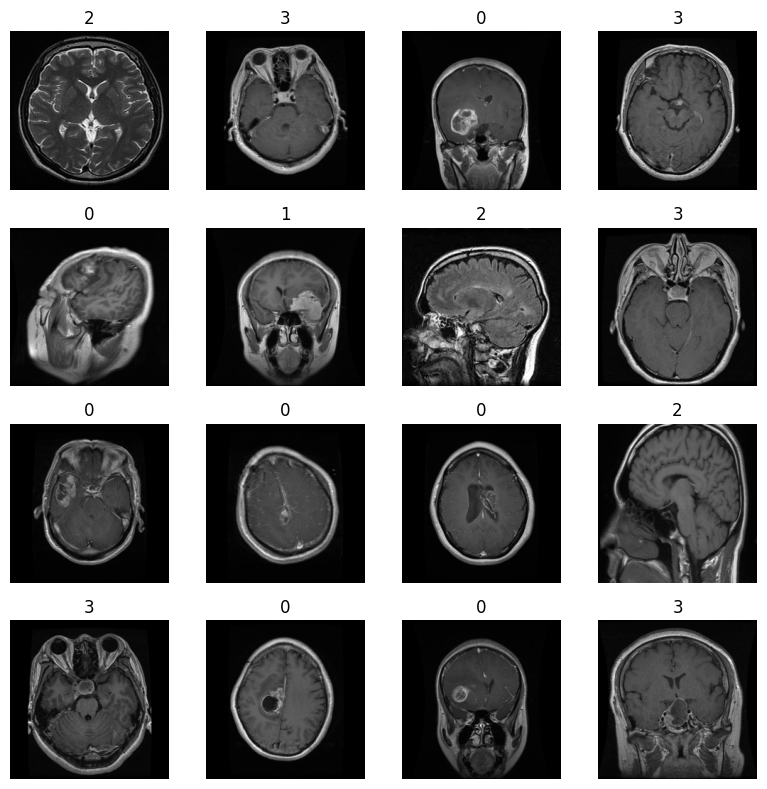

In [10]:
batch_size = 16
shuffle = True
training_dataset = BrainDataset(os.path.join(dataset_path, "Training"), training_csv_path)
training_dataloader = tc.utils.data.DataLoader(training_dataset, batch_size=batch_size, shuffle=shuffle)

for images, classes in training_dataloader:
    # TODO - perform the same visualization as before but this time using the new version of the dataset
    fig, axs = plt.subplots(4, 4, figsize=(8, 8))
    for i, image in enumerate(images):
        row_id = i // 4
        col_id = i % 4
        axs[row_id][col_id].set_title(classes[i].item())
        axs[row_id][col_id].imshow(image[0], cmap='gray')
        axs[row_id][col_id].axis("off")
    fig.tight_layout()
    break

You should be now familiar with implementing your own Datasets. The next part is for you to train - you are going to implement another one from scratch, without any additional guides.

### Part IV - Endoscopy Dataloader

In this part you are going to implement dataset dedicated to image segmentation (to be then used during Laboratory 6). 

The dataset is dedicated to the segmentation of surgical instruments from endoscopy images and comes from:

https://www.kaggle.com/datasets/debeshjha1/kvasirinstrument

We will use the dataset during Laboratory 6 because endoscopy images are relatively low resolution 2-D images than can be easily processed using Google Colaboratory. In reality they are video sequences, however, you are going to process just single frames.

Download the dataset and repeat the steps from the previous parts of the laboratory. Start with creating the dataset:

In [12]:
import pandas as pd
import json

dataset_path = "Instruments_Endoscopy\\kvasir-instrument"

with open(os.path.join(dataset_path, "train.txt")) as f:
    training_names = f.readlines()
    training_names = [name.rstrip() for name in training_names]

with open(os.path.join(dataset_path, "test.txt")) as f:
    testing_names = f.readlines()
    testing_names = [name.rstrip() for name in testing_names]

with open(os.path.join(dataset_path, "bboxes.json")) as f:
    bboxes = json.load(f)

training_csv_path = os.path.join(dataset_path, "train.csv")
testing_csv_path =  os.path.join(dataset_path, "test.csv")

# Repeat the process from the __init__ function to create pandas dataframe
# containing three components: (image_path, image_class_number, image_class_name)

# - create the dataframes

# for case_type, extension in zip(["images\\images", "masks\\masks"], [".jpg", ".png"]): # for images and masks
    # for folders: image and masks
    # all items in folder
dir_df = pd.DataFrame([os.path.join("images\\images", path)
                       for path in os.listdir(os.path.join(dataset_path, "images\\images"))], columns=['images'])
dir_df['masks'] = [os.path.join("masks\\masks", path)
                   for path in os.listdir(os.path.join(dataset_path, "masks\\masks"))]
dir_df['name'] = [os.path.splitext(file)[0] for file in os.listdir(os.path.join(dataset_path, "images\\images"))]

dir_df['height'] = [bboxes[element]['height'] for element in dir_df['name']]
dir_df['width'] = [bboxes[element]['width'] for element in dir_df['name']]
dir_df['bbox'] = [bboxes[element]['bbox'] for element in dir_df['name']]

# proceed the left join on directory dataframe
training_tmp = pd.DataFrame(training_names, columns=["name"])
testing_tmp = pd.DataFrame(testing_names, columns=["name"])


train_df = pd.merge(dir_df, training_tmp, on='name', how="left")
test_df =  pd.merge(dir_df, testing_tmp, on='name', how="left")
    
# image_name, mask_name, height, width, label, xmin, ymin, xmax, ymax
        
# save them to .csv

train_df.to_csv(training_csv_path)
test_df.to_csv(testing_csv_path)

Creating the dataset

In [13]:
class EndoscopyDataset(tc.utils.data.Dataset):
    def __init__(self, dataset_path, csv_path, transforms=None, z_norm=False):
        self.dataset_path = dataset_path
        self.csv_path = csv_path
        self.dataframe = pd.read_csv(self.csv_path, names=[
            'images', 'masks', 'name', 'height', 'width', 'bbox'
        ], skiprows=1) # - read the previously created csv
        
        # use skiprows if the header is not correctly assigned (like in my case)
                
    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        # - repeat the steps from the previous dataloader
        row = self.dataframe.iloc[idx]
                
        current_image_loc   = row[0]
        current_mask_loc    = row[1]
        current_name        = row[2]
        current_height      = row[3]
        current_width       = row[4]
        current_bbox_list   = row[5]
        
        self.new_size = (224, 224)
        
        current_image = np.array(
            Image.open(
                os.path.join(
                    self.dataset_path, current_image_loc
                )
            ) .resize(self.new_size)  # resize do (224x224)
        ).astype(np.float32)
        
        current_mask = np.array(
            Image.open(
                os.path.join(
                    self.dataset_path, current_mask_loc
                )
            ) .resize(self.new_size)  # resize do (224x224)
        ).astype(np.float32)
        
        # All images should have the same resolution
        # Resample the images to the same resolution (224x224), then convert the images to grayscale (if not already) and normalize to [0-1] values

        current_image *= (255.0/current_image.max())
        current_mask *= (255.0/current_mask.max())
        
        # To pytorch
        current_image = tc.from_numpy(current_image)
        current_mask = tc.from_numpy(current_mask)
    
        # reshape so that channels are first:
        new_shape = (3, *self.new_size)
        current_image = tc.reshape(current_image, new_shape)
        current_mask = tc.reshape(current_mask, new_shape)
        return current_image, current_mask, current_bbox_list

Then create the dataloader:

In [17]:
batch_size = 4
shuffle = True
training_dataset = EndoscopyDataset(dataset_path, training_csv_path)
training_dataloader = tc.utils.data.DataLoader(training_dataset, batch_size=batch_size, shuffle=shuffle)
print(f"Dataset size: {len(training_dataset)}")

Dataset size: 590


And finally visualize the images with the corresponding segmentation masks:

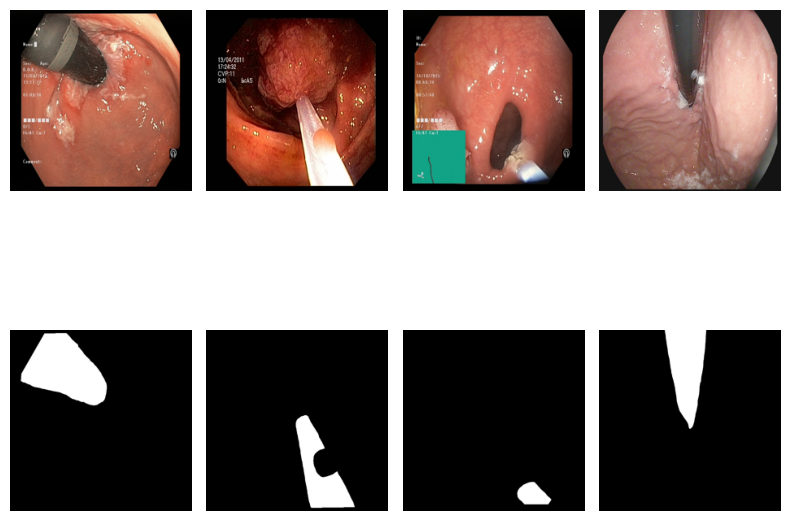

In [19]:
for images, masks, bboxes in training_dataloader:
    # - perform the same visualization as before but this time using the new version of the dataset
    fig, axs = plt.subplots(2, 4, figsize=(8, 8))
    for i, image in enumerate(images):
        # axs[0][i].set_title(classes[i].item())
        image.reshape(224, 224, 3)
        axs[0][i].imshow(image.reshape(*training_dataset.new_size, 3).type(tc.uint8), cmap='gray')
        axs[0][i].axis("off")
        
        axs[1][i].imshow(masks[i].reshape(*training_dataset.new_size, 3).type(tc.uint8), cmap='gray')
        axs[1][i].axis("off")
        
    fig.tight_layout()
    break

### Conclusion

Congratulations, you have implemented several datasets dedicated to load medical images. You should be now able to implement you own dataset whenever necessary.

After the laboratory you should:
<ul>
  <li> Understand the difference between Dataset and Dataloader objects.
  <li> Implement your own Dataset object for a given medical dataset.
  <li> Use the Dataloader object with any Dataset to load the data using the desired hyperparameters.
  <li> Verify whether the Dataloader works and loads the data appropriately.
</ul>

During the next laboratory you are going to combine the knowledge from Laboratory 2 and Laboratory 3 to implement and train a simple convolutional neural network for medical image classification.